In [1]:
import json
import numpy as np
import random

from lttb import LTTB

from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod

# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [2]:
"""
sigma_in = 5
!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e
   sovrapporre angoli di training
-> sparsificare l'input e/o il contesto
-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)
-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;
   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre
   i bottoni su una circonferenza di raggio fissato
"""

"\nsigma_in = 5\n!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e\n   sovrapporre angoli di training\n-> sparsificare l'input e/o il contesto\n-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)\n-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;\n   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre\n   i bottoni su una circonferenza di raggio fissato\n"

In [19]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

n_examples = 100

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

#train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])

train_targs = (np.random.rand(n_examples,2)-.5)*2#np.array ([( np.random.rand(1) , np.random.rand(1) ) for t in train_theta])

train_thetas = [random.random()*2*np.pi for i in range(n_examples)]
train_thetas_targ = [random.random()*2*np.pi for i in range(n_examples)]


#train_thetas = np.linspace(0,2*np.pi,n_examples,endpoint=False)

train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
train_targs = train_bttns + np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas_targ])
#train_bttns = (np.random.rand(20,2)-.5)*2#np.array ([(0, rb) for t in train_theta])

#valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])


In [20]:
np.shape(train_targs)

(100, 2)

In [21]:

#valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

tb = 60
tf = 60

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, tf-1), 'T' : (tb, tf)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]



In [22]:
train_bttns

array([[ 0.8395913 ,  0.5432186 ],
       [ 0.40410919,  0.91471075],
       [ 0.60910164, -0.79309217],
       [-0.66658484,  0.74542917],
       [-0.93004431, -0.3674474 ],
       [ 0.99942956, -0.033772  ],
       [-0.92740305,  0.3740636 ],
       [-0.60335229, -0.79747477],
       [ 0.84958577, -0.5274505 ],
       [ 0.02027849, -0.99979437],
       [-0.75964015,  0.65034364],
       [ 0.95855406,  0.28491072],
       [-0.8691454 , -0.49455664],
       [ 0.68023258, -0.73299634],
       [-0.03154018, -0.99950248],
       [-0.16588473,  0.98614515],
       [ 0.25603506,  0.9666675 ],
       [ 0.06636421, -0.99779547],
       [-0.11099194, -0.99382131],
       [ 0.75127226,  0.65999241],
       [-0.71516963,  0.69895093],
       [ 0.10181586, -0.99480326],
       [ 0.99496137,  0.10025907],
       [-0.30384944, -0.95272006],
       [-0.99772024, -0.06748571],
       [-0.85943189,  0.51125026],
       [ 0.66389061, -0.7478297 ],
       [-0.7222082 , -0.69167573],
       [-0.54412686,

In [23]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 80, 2, tb
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 50.
sigma_targ = 0. #10**1.5
sigma_in = 20. #12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = n_examples

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 2

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb = LTTB (par)


In [24]:
# define clock and target

lttb.y_targ_collection = []
lttb.I_clock_collection = []

for k in range(n_contexts):
    
    lttb.y_targ_collection.append( train_exp[k][1] )
    lttb.I_clock_collection.append( train_exp[k][0] )
    
    #lttb.y_targ_collection.append( train_exp[k][1].T[0:tb].T )
    #lttb.I_clock_collection.append( train_exp[k][0].T[0:tb].T )

In [25]:
"""
for k in range(n_contexts):

    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(212)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')
"""

"\nfor k in range(n_contexts):\n\n    plt.figure()\n    plt.subplot(311)\n    plt.plot(np.array(lttb.y_targ_collection[k]).T)\n    plt.ylabel('$y_{targ}$')\n    plt.subplot(212)\n    plt.plot(np.array(lttb.I_clock_collection[k]).T)\n    plt.xlabel('time(s)')\n    plt.ylabel('clock')\n"

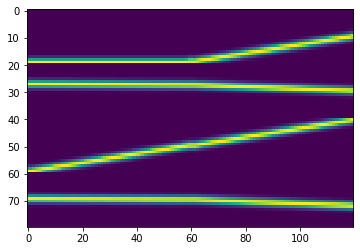

In [26]:
plt.imshow(np.array(lttb.I_clock_collection[5]))


<Figure size 432x288 with 0 Axes>

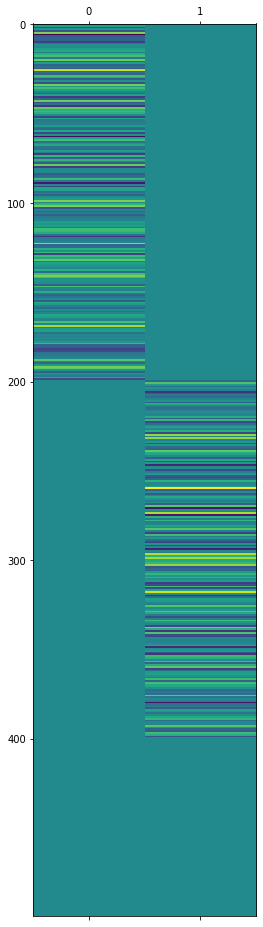

In [27]:
lttb.j_cont[200:,0]=0
lttb.j_cont[0:200,1]=0
lttb.j_cont[400:,1]=0


np.shape(lttb.j_cont)

plt.figure()
plt.matshow(lttb.j_cont,aspect='auto')
plt.show()

In [29]:
## Training Rec
par['T'] = tb+tf
lttb.T = tb+tf
    
gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 200

eta = 0.
eta_out = 0.025
etaW = .0

##############################

SR_list = []

for cont_index in range(n_contexts):
        
        lttb.initialize(par)
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.cont = lttb.cont*0
        lttb.cont[0] = 1

        for t in range(lttb.T-2):
            
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
                
            lttb.step(apicalFactor = apicalFactorTrain)
            
            SR = lttb.B_filt[:,t+1]#lttb.S_filtRO[:,t+1]#
        SR_list.append(lttb.B_filt)
        
            

            

In [30]:
#####################################
            
test_every = 5

ERRORS = np.zeros((int(nIterRec/test_every),n_contexts))
for iteration in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_contexts):
        
        
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        
        #ON-LINE
        
        """
        lttb.initialize(par)
        
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.cont = lttb.cont*0
        lttb.cont[0] = 1
        
        #run simulation
        dH = 0

        for t in range(lttb.T-2):
            
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
                
            lttb.step(apicalFactor = apicalFactorTrain)
            
            SR = lttb.B_filt[:,t+1]#lttb.S_filtRO[:,t+1]#
            Y = lttb.Jout@SR
            DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
            lttb.Jout =  lttb.Jout + eta_out*DJRO
        
        """
        #OFF-LINE
        
        SR = SR_list[cont_index]
        Y = lttb.Jout@SR
        DJRO = (lttb.y_targ[:,1:-1] - Y[:,0:-2]) @ ( SR.T[0:-2])
        lttb.Jout =  lttb.Jout + eta_out*DJRO
        
    ###### Test
    
    if iteration%test_every==0:

        for cont_index in range(n_contexts):
            
            lttb.initialize(par)
            lttb.y_targ = lttb.y_targ_collection[cont_index]
            lttb.I_clock = lttb.I_clock_collection[cont_index]
            
            
            lttb.cont = lttb.cont*0
            lttb.cont[0] = 1

            #run simulation

            for t in range(lttb.T-2):
                
                if t==tb:
                    lttb.cont = lttb.cont*0
                    lttb.cont[1] = 1
                
                lttb.step(apicalFactor = apicalFactorTest)

            SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]# 
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

            ERRORS[int(iteration/test_every),cont_index] = mse_rec_train

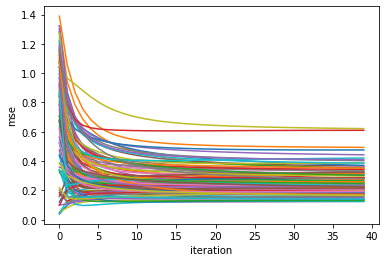

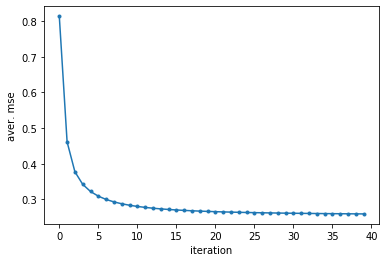

In [31]:
plt.figure()
plt.plot(ERRORS)
plt.xlabel("iteration")
plt.ylabel("mse")
plt.show()

plt.plot([np.mean(ERRORS[_,:]) for _ in range(len(ERRORS))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")
plt.show()

0.20729714828572335


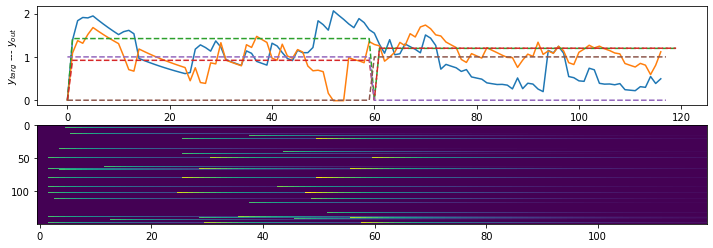

0.4933920764026294


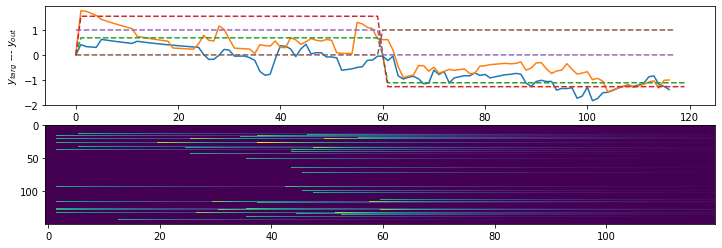

0.2595651120024362


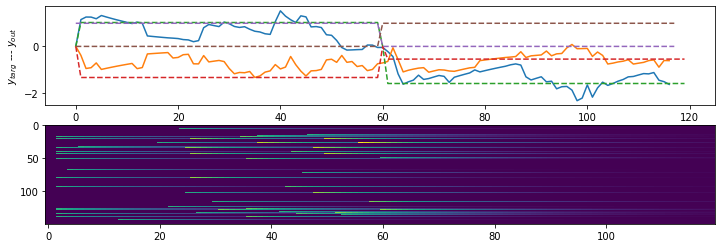

0.19166556987551162


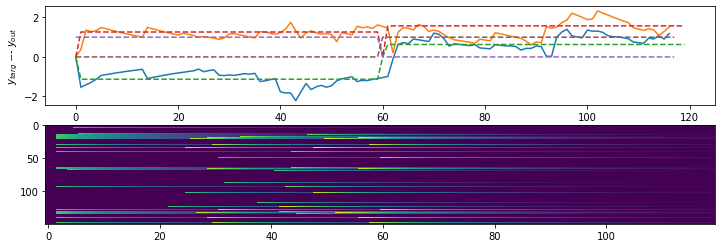

0.19294373490922817


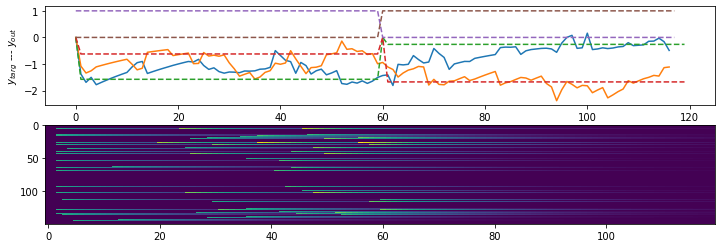

0.1692228222675644


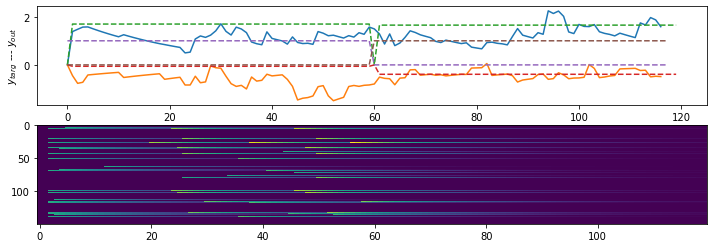

0.3293131061328456


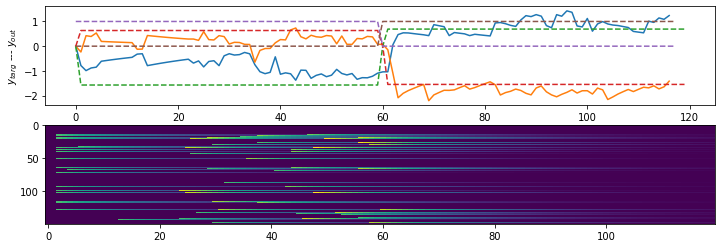

0.20378264321964604


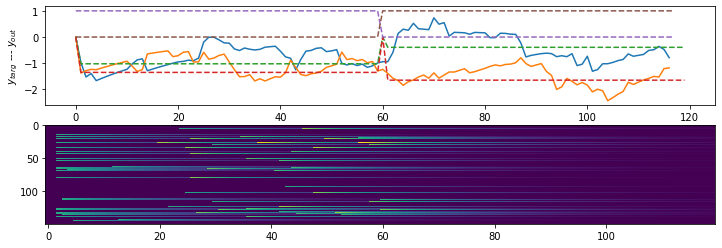

0.16605013165096033


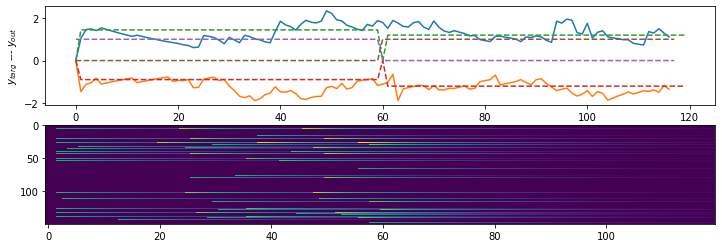

0.19588808573533892


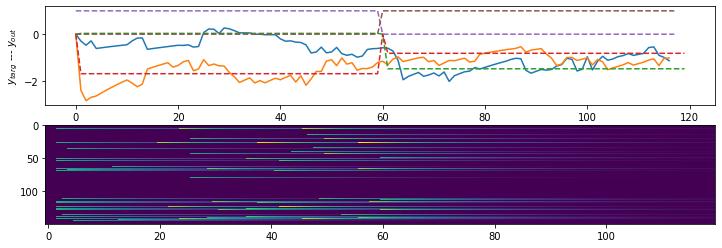

0.28240881920700106


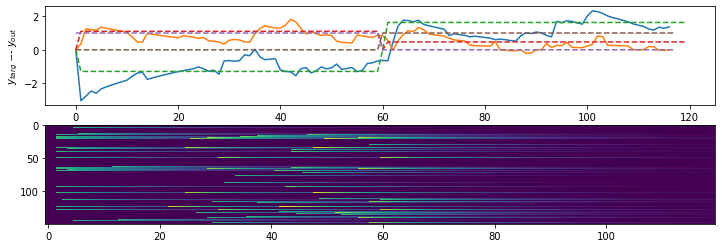

0.35478380232005896


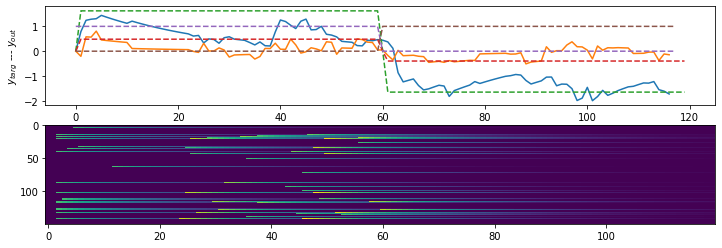

0.1505590429454988


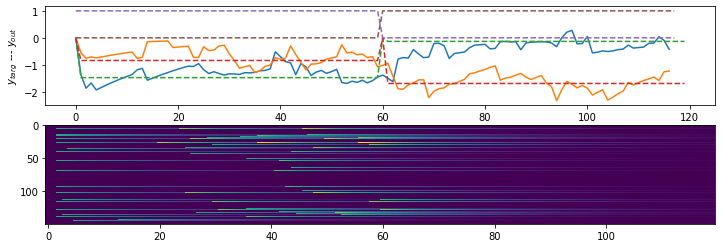

0.2783131952599925


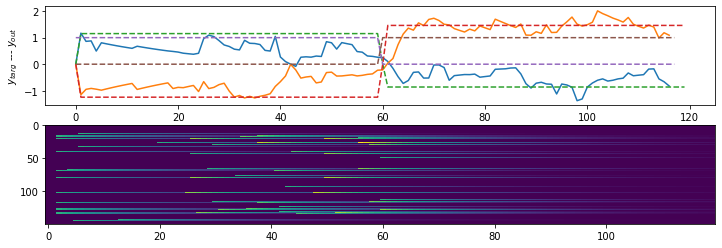

0.1493976963299977


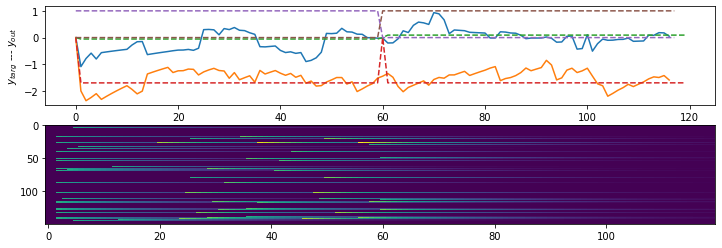

0.364807915313251


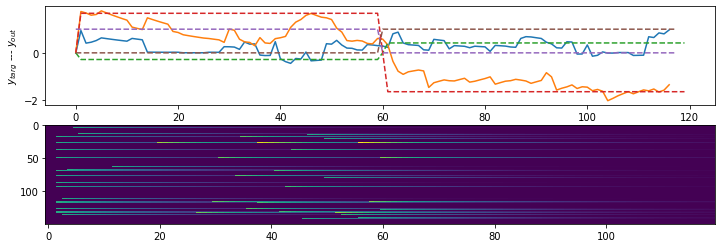

0.3582455591176651


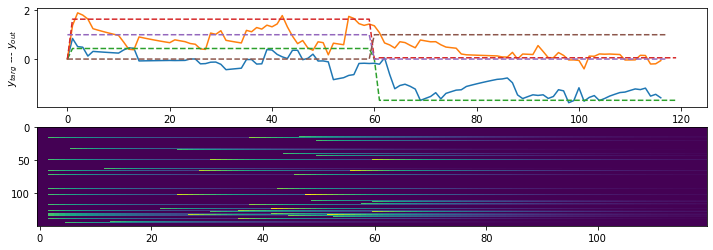

0.30328212972827623


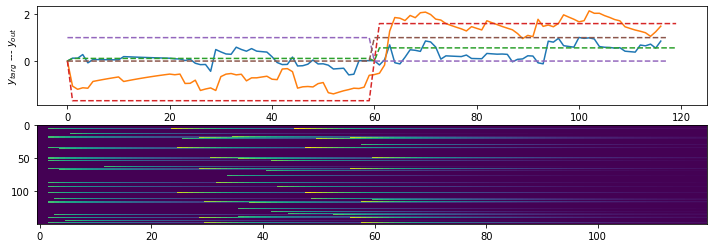

0.2204495547896869


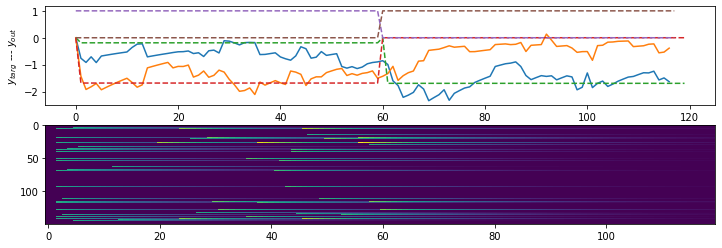

0.23530849519566346


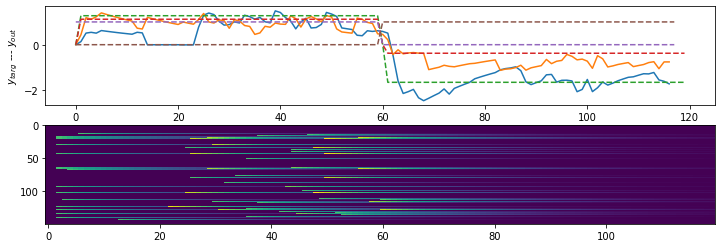

0.2301334505292624


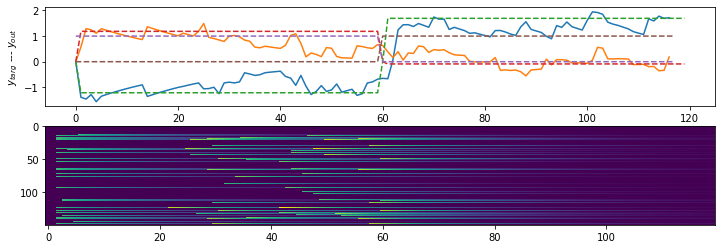

0.20759160125284806


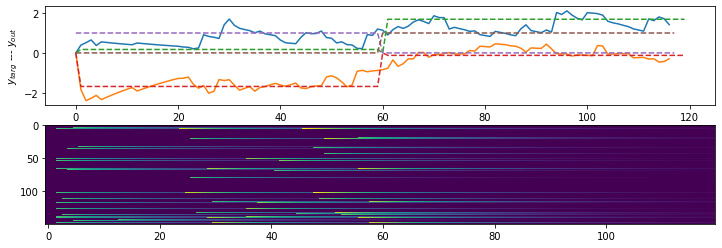

0.23125556738369912


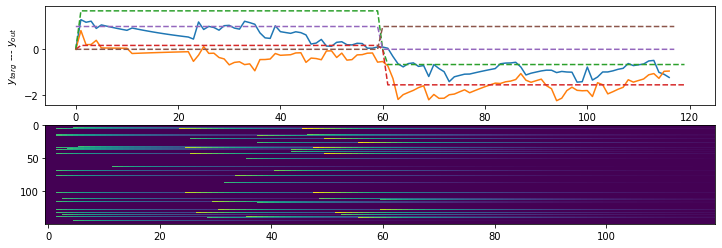

0.28112157835829354


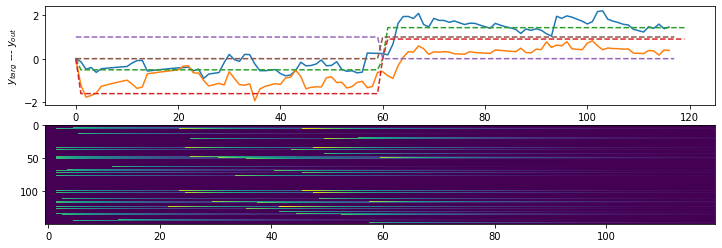

0.24489149108024372


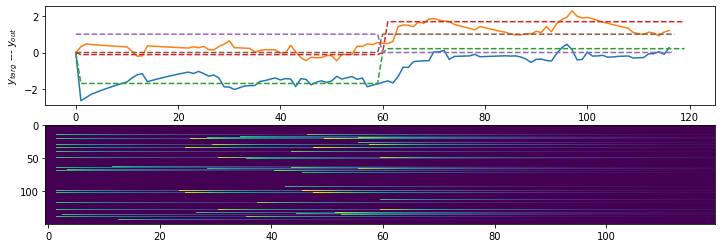

0.250792983074883


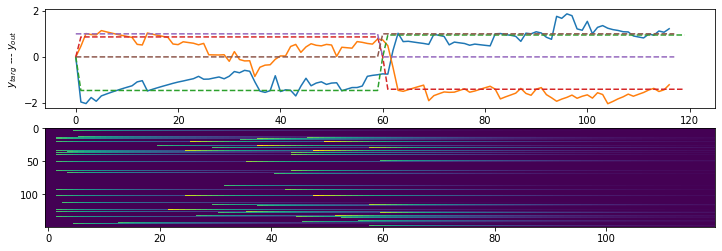

0.12560178555500198


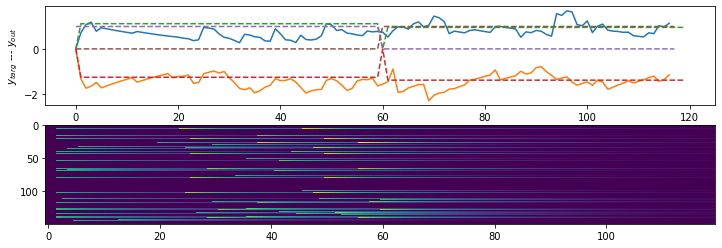

0.32722112433064865


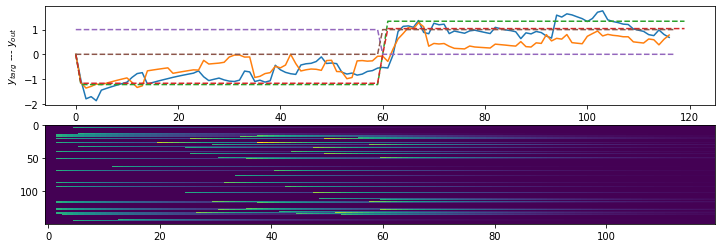

0.2500684196876714


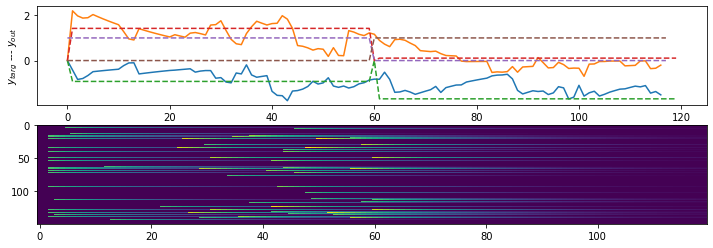

0.17539680443829606


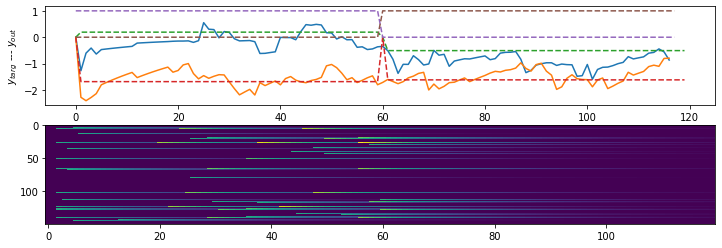

0.369962476283643


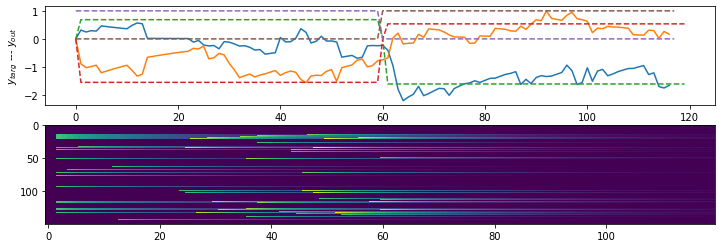

0.27665735899250926


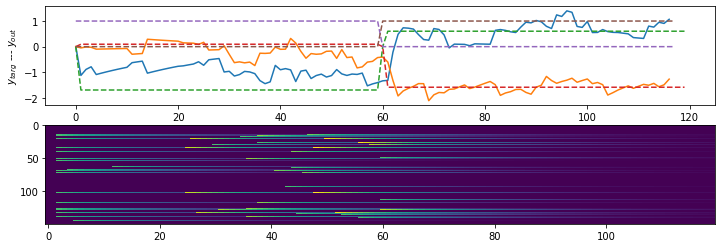

0.2663514860381636


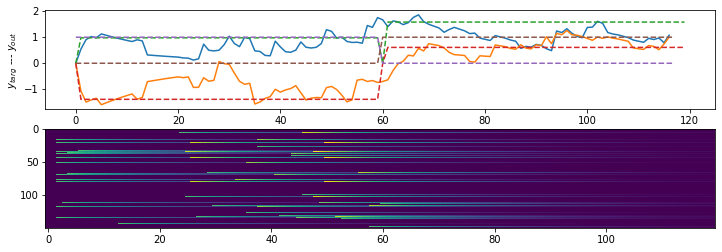

0.22301089287736445


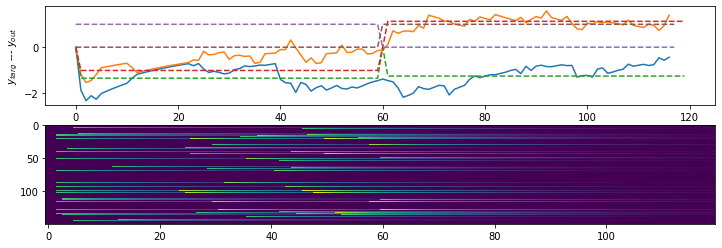

0.2256217141966562


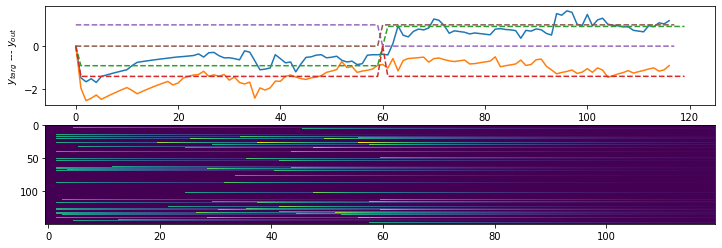

0.21747855749271458


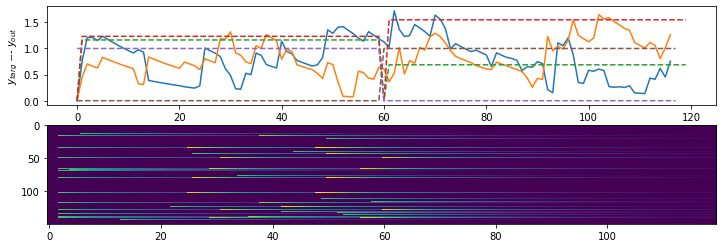

0.3102114821635661


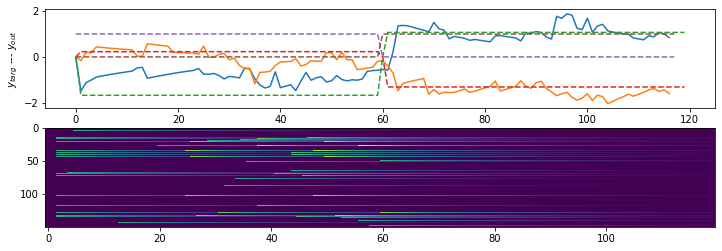

0.30553460785262665


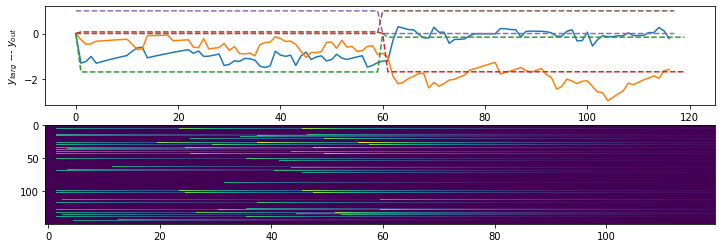

0.13756853002034913


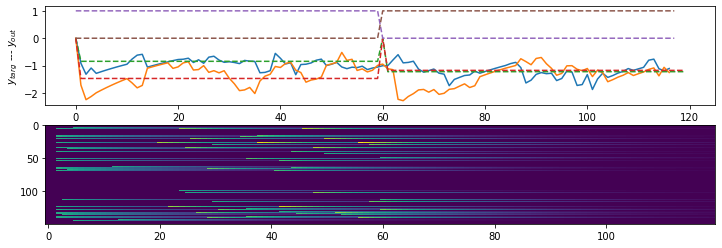

0.12404782602152463


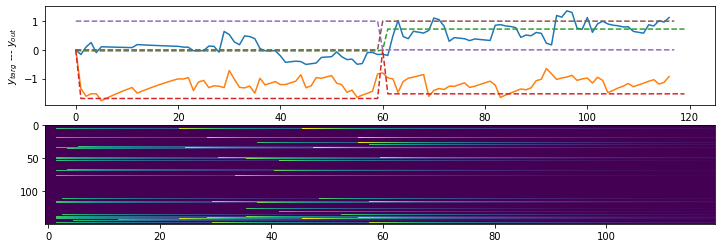

0.17027004844975419


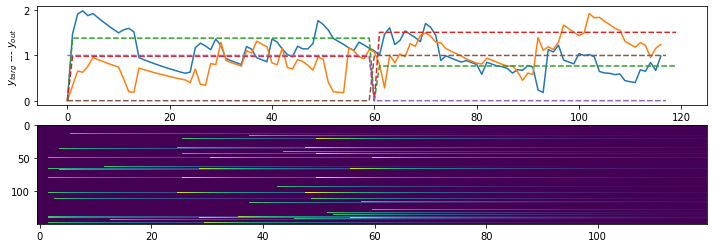

0.31969077104611726


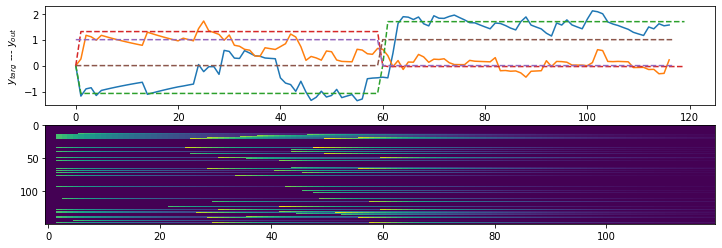

0.34980573154662437


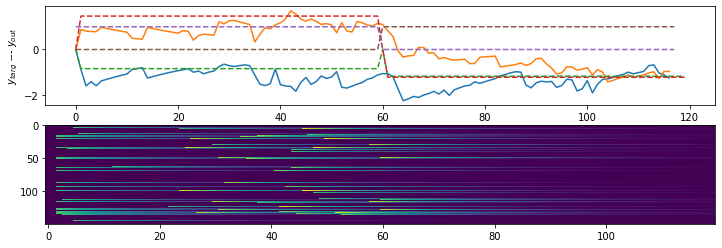

0.20200330495429117


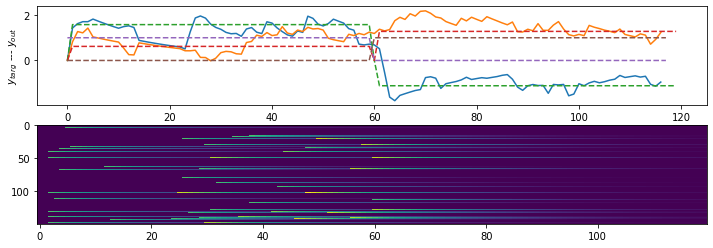

0.24097248414688108


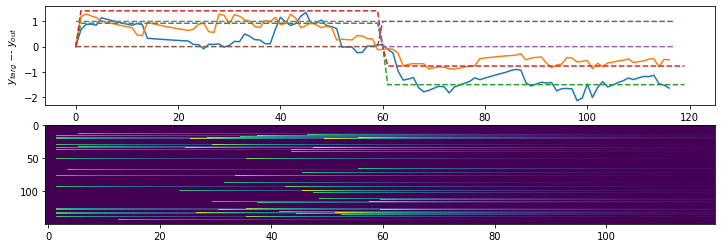

0.21543807790308614


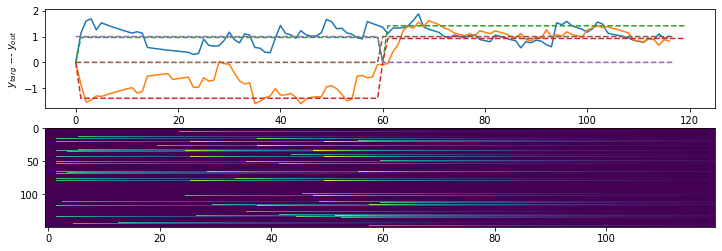

0.3231816697052357


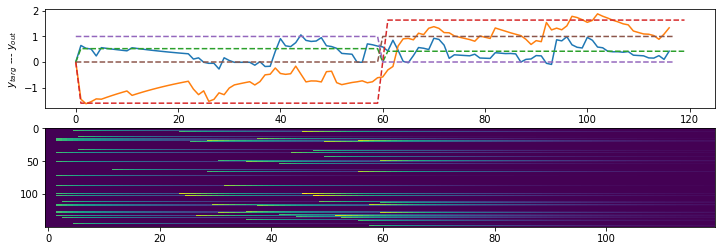

0.33408572703884987


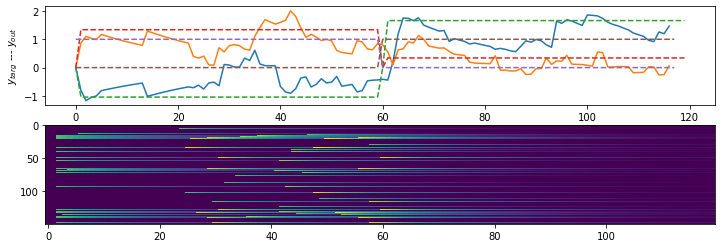

0.6210882077291486


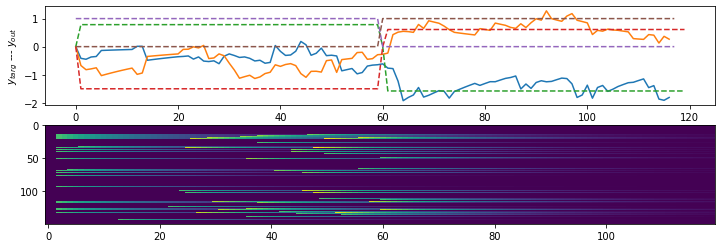

0.1661322831060905


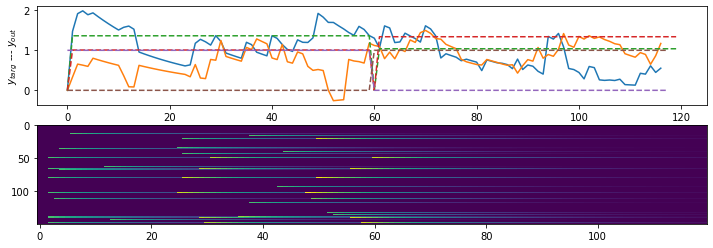

0.28646852344562923


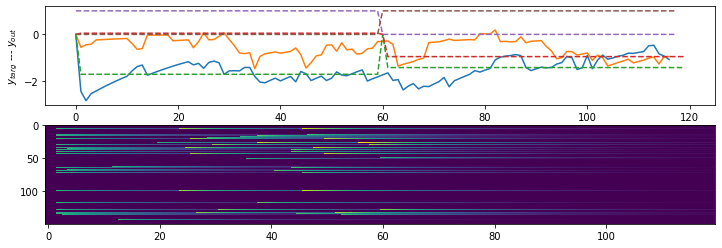

0.31738942036194756


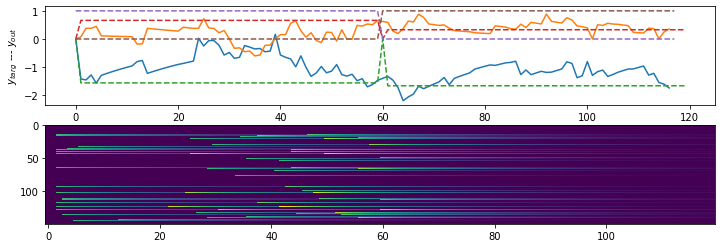

0.2303160103496819


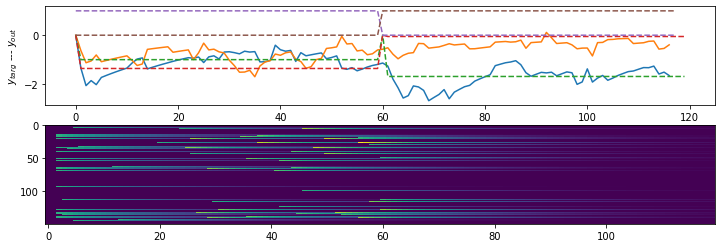

0.28740501171024074


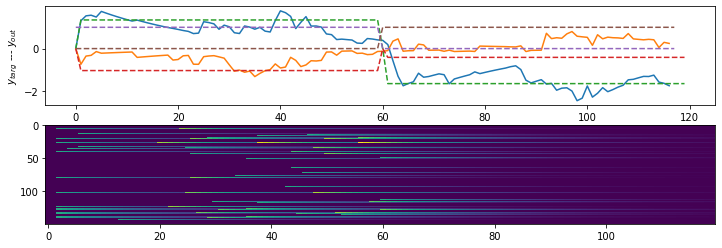

0.17777968841260702


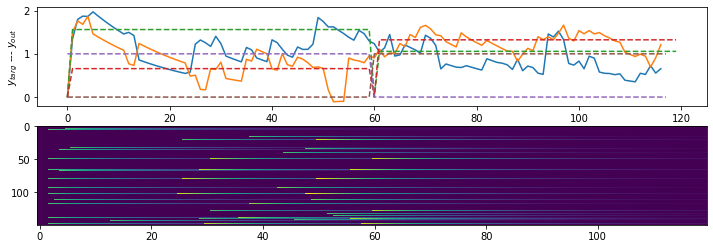

0.22230589548397411


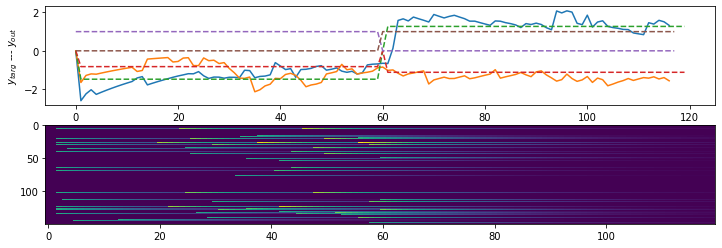

0.23294419341952868


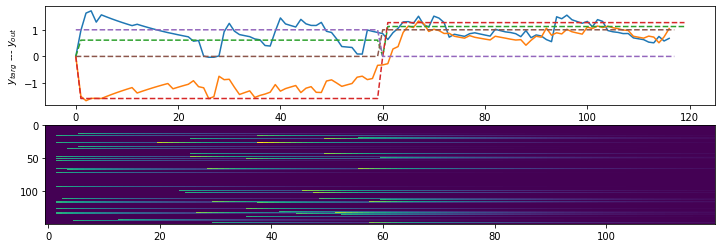

0.4022330019715656


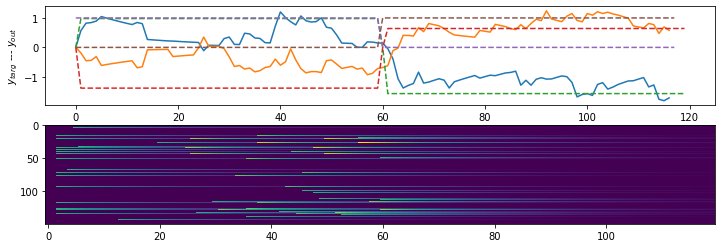

0.3883487914574748


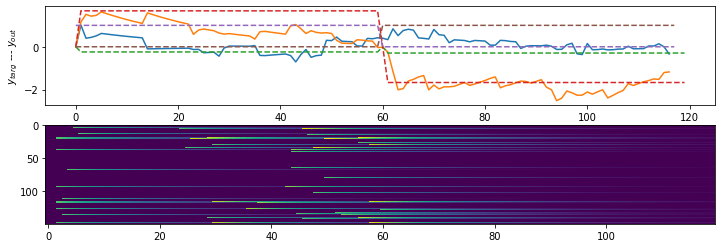

0.3857140679098582


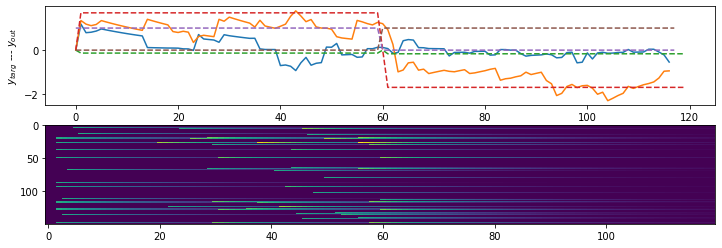

0.22356477512783923


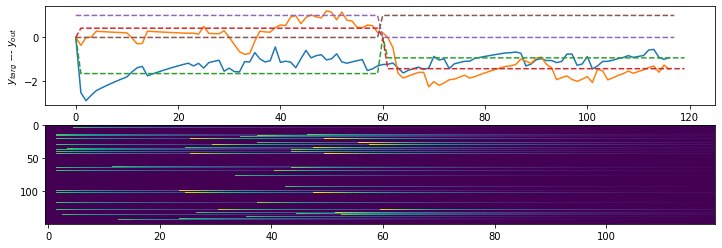

0.2591674992794014


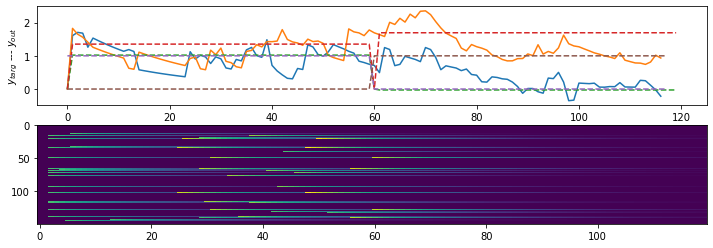

0.23115948515703255


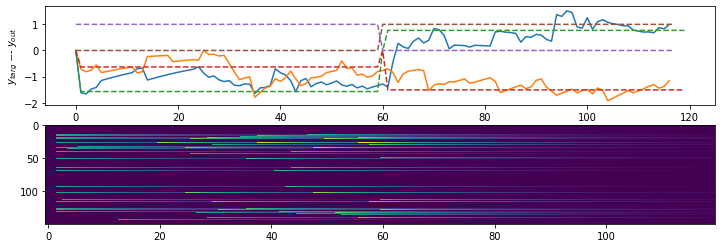

0.3440716603345362


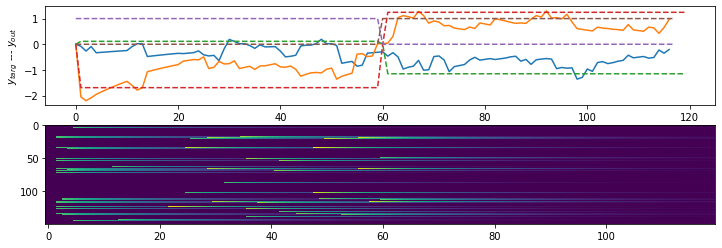

0.4424402320670569


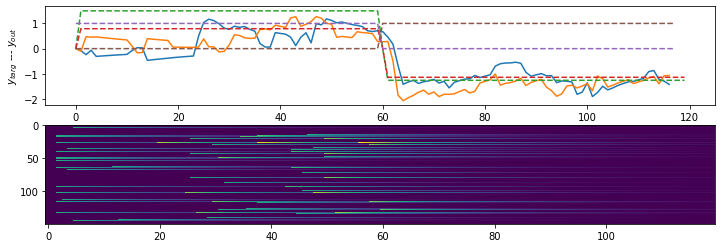

0.3234241375789227


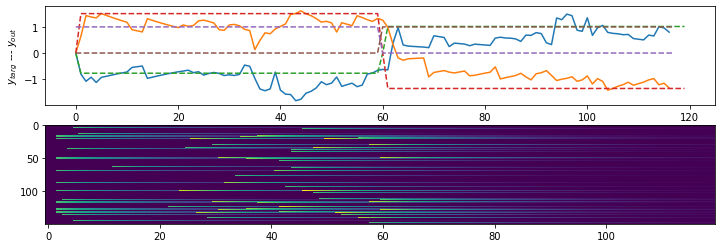

0.23824397861425176


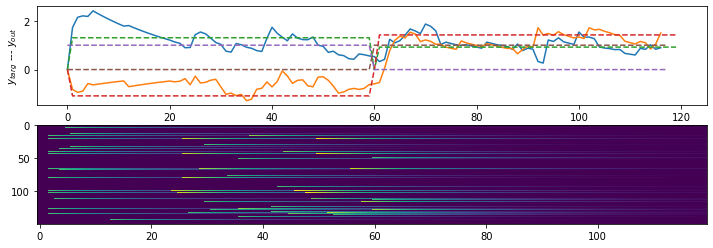

0.15972889554855335


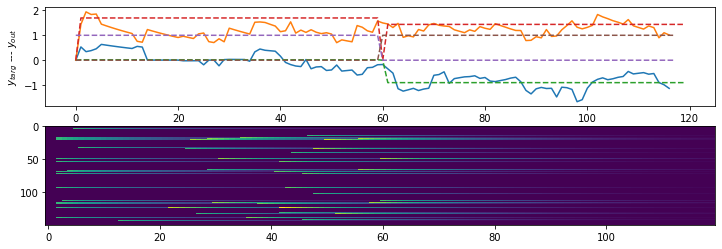

0.29768018084156533


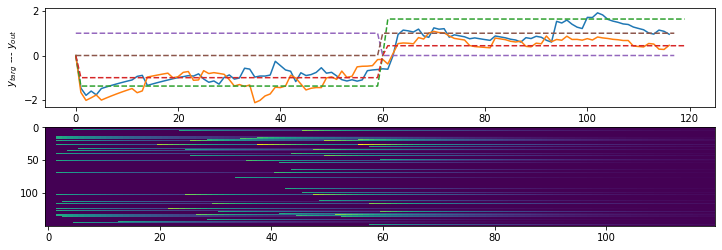

0.22827477549616418


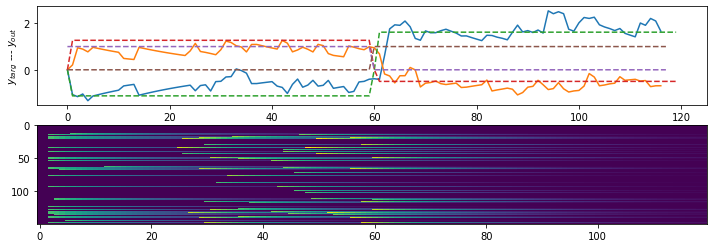

0.47626675108161576


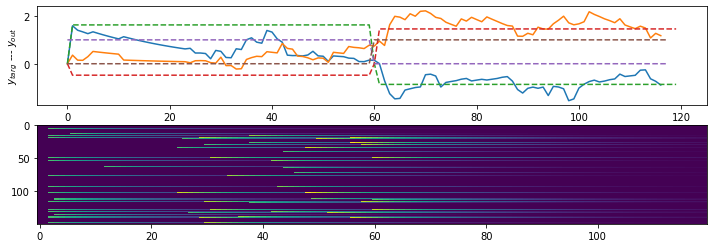

0.35058172626219153


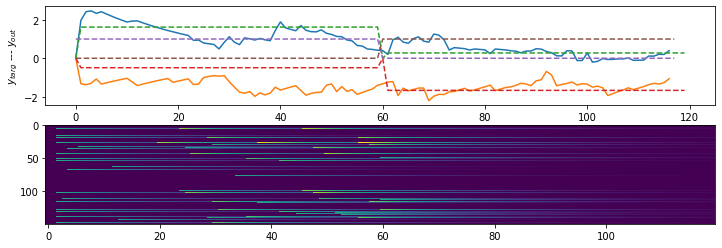

0.30257451751224257


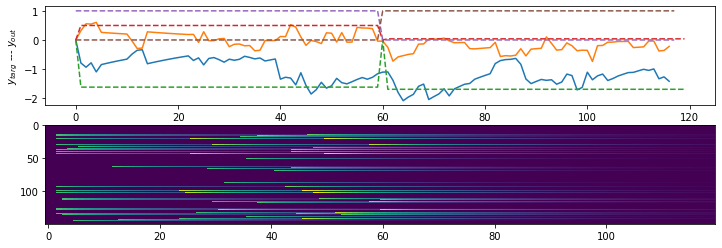

0.1770618731192712


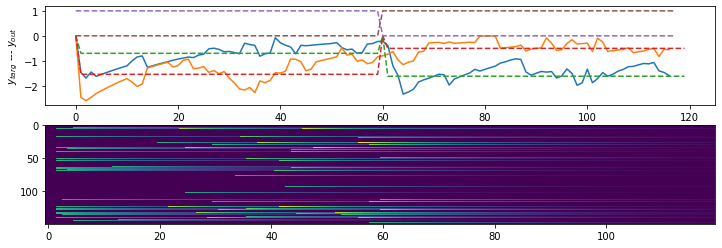

0.14199843780999055


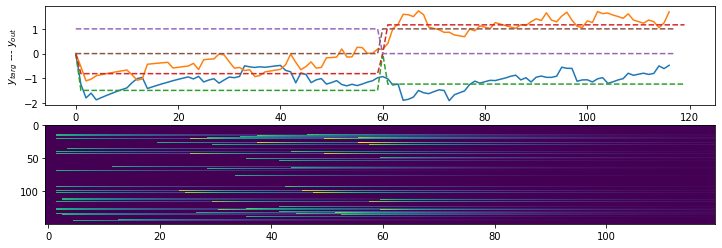

0.22017748380285726


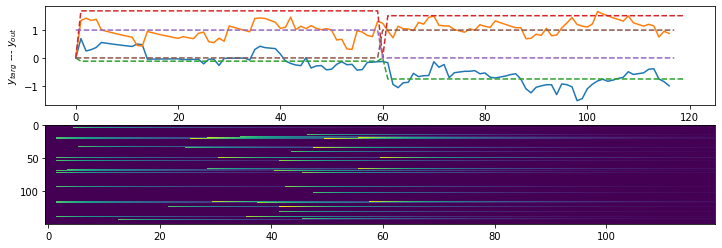

0.2041345178971225


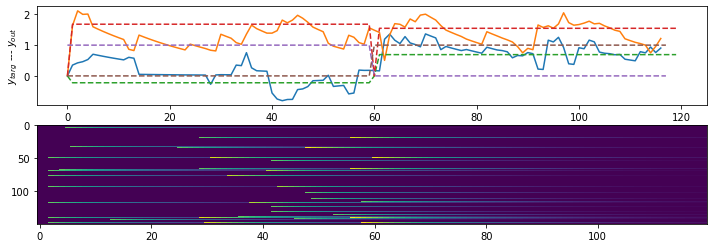

0.18470037076504311


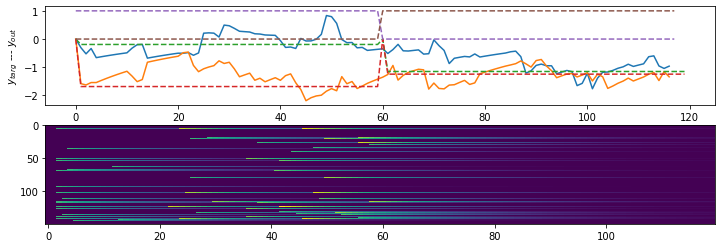

0.24445869533245565


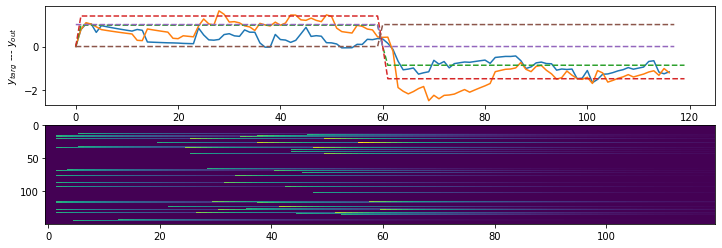

0.4215074337775621


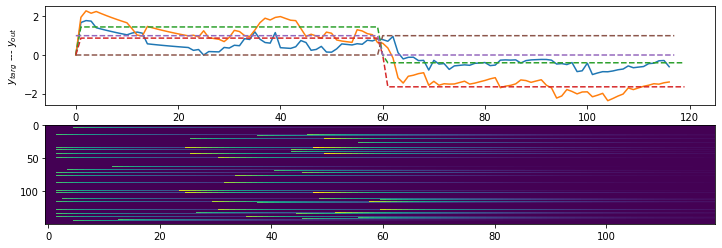

0.1353476149064143


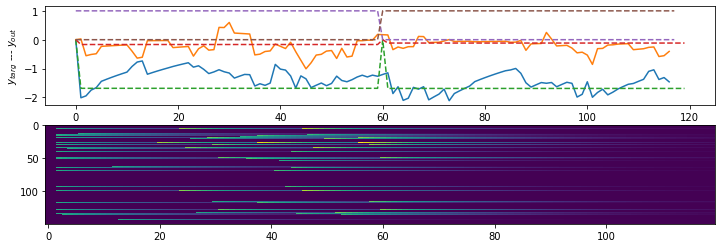

0.22372901830710284


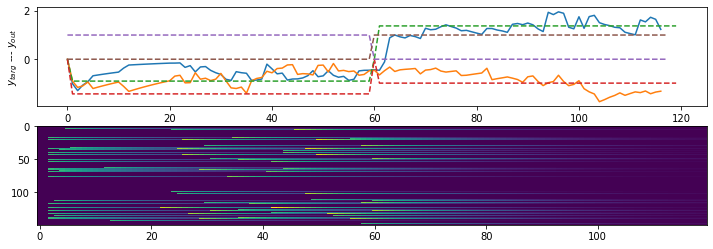

0.1311377604190743


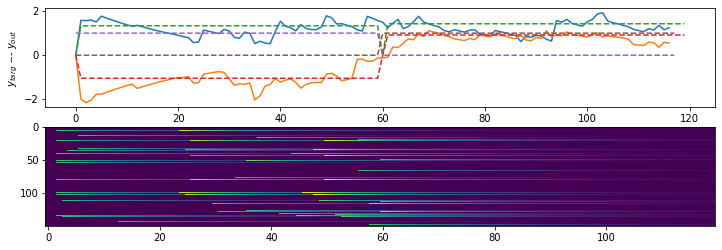

0.2352814103464021


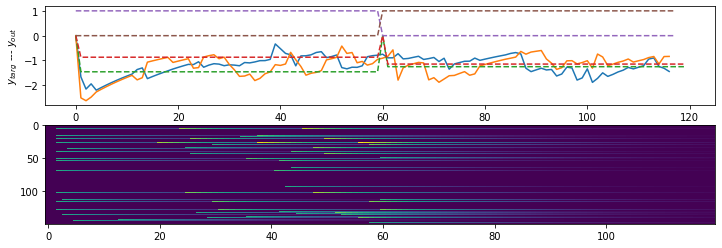

0.40973581242076434


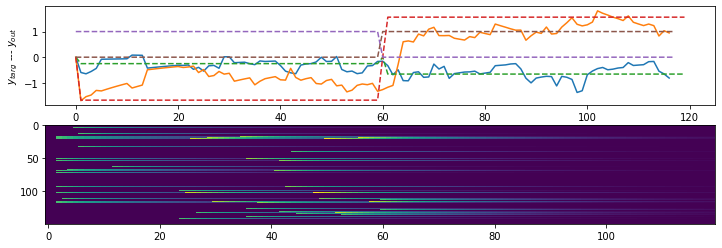

0.21428747810995405


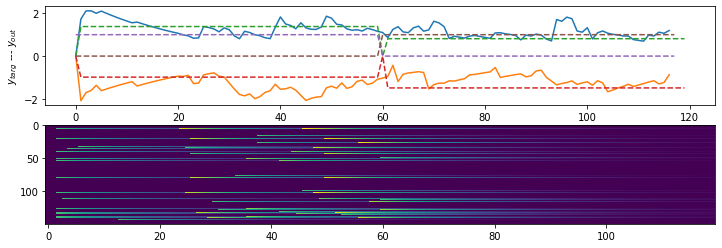

0.23254287065086918


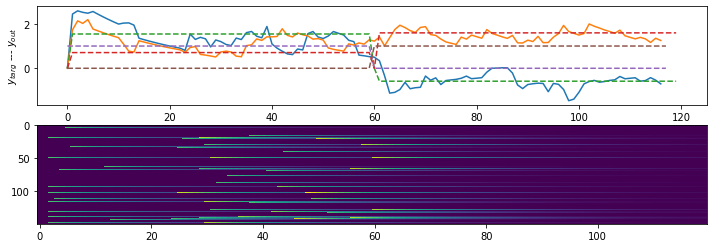

0.22890844073149563


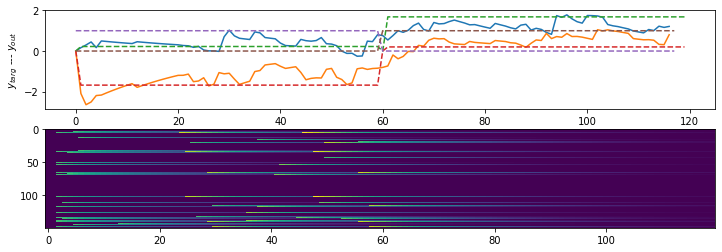

0.1955800610442063


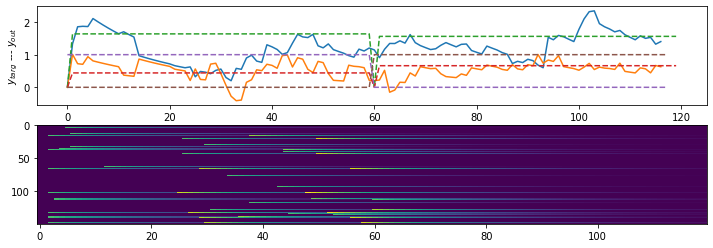

0.2333046295119464


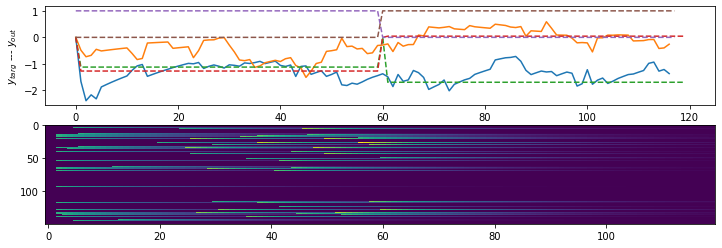

0.18696895309230604


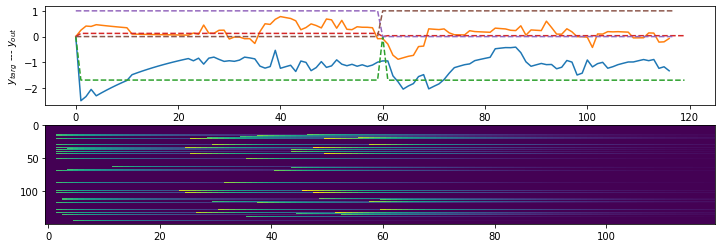

0.1702475626211902


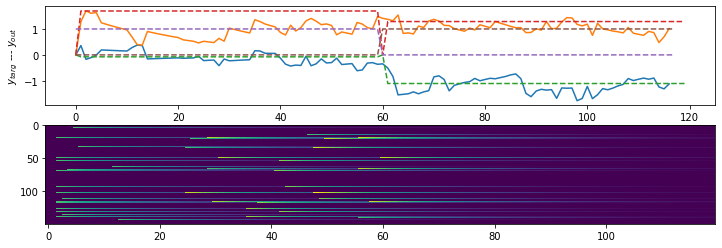

0.24734107581045098


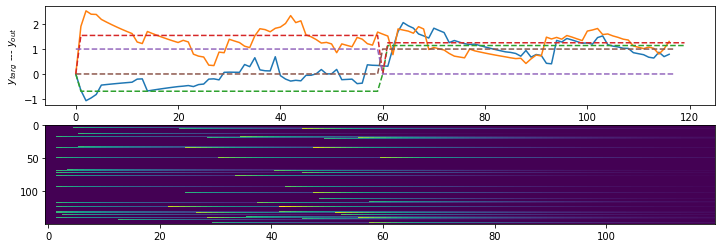

0.6099611225364935


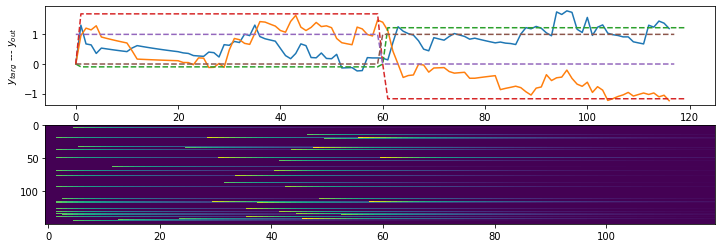

0.2309751386335027


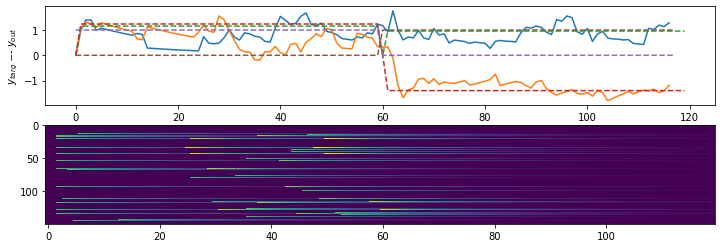

0.22444496859745697


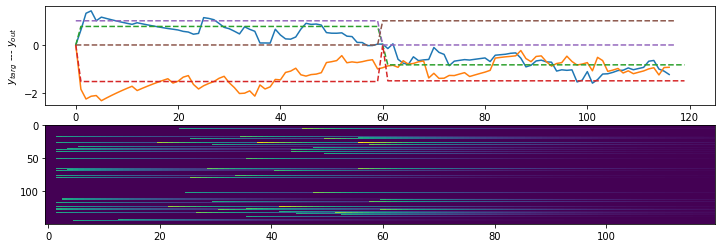

0.1918744396523306


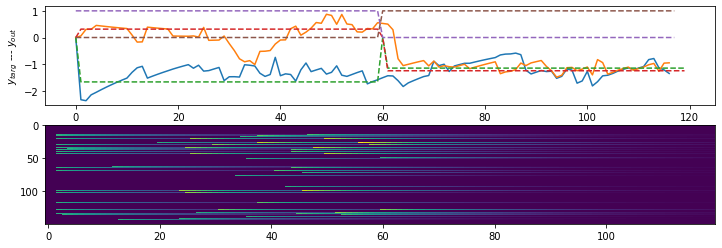

0.2807300225155623


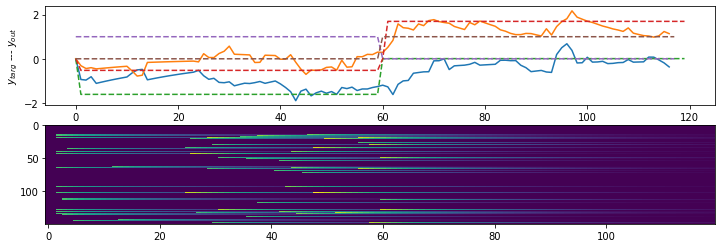

0.16686039169516792


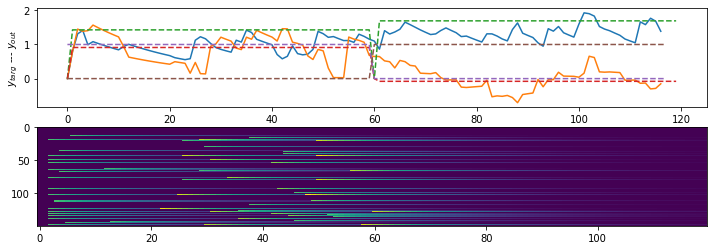

0.1417291855622406


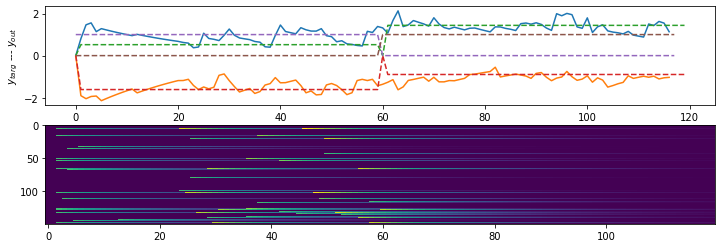

In [32]:
for cont_index in range(n_contexts):
    
    context = []

    lttb.initialize(par)
    lttb.I_clock = lttb.I_clock_collection[cont_index]
    lttb.y_targ = lttb.y_targ_collection[cont_index]
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    #run simulation
    
    apicalFactor = 0
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    for t in range(lttb.T-2):
 
        if t==tb:
           
            lttb.cont = lttb.cont*0
            lttb.cont[1] = 1
        context.append(lttb.cont)
        
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y.T)
    plt.plot(lttb.y_targ.T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.B_filt[0:150,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [385]:
np.random.normal(loc=0, scale=0.1)

-0.13117604185062837

In [452]:
def make_test(btn, targ, show_plot=True):
    
    TIME_TEST = 1500

    par['T'] = TIME_TEST
    lttb.T = TIME_TEST
    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    #targ_test = train_targs[cont_index]
    #btn_test = train_bttns[cont_index]

    #theta = 30
    #theta = theta/180*np.pi
    #targ_test = (np.random.rand(2)-.5)
    #btn_test = (np.random.rand(2)-.5)
    
    btn_radius = 0.1
    #btn_dist = 1.0
    #btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    #btn = btn_test
    
    #targ_test = np.array(btn_test) + np.array((btn_dist * np.cos (targ_theta), btn_dist * np.sin (targ_theta)))
    
    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ, btn = btn)

    agen = init
    
    cont_noise = 0.05
    
    R = 0

    ACTIONS = []
    POSITION = []#np.zeros((2,TIME_TEST-2))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont[0] = 1 + np.random.normal(loc=0, scale=cont_noise)
    lttb.cont[1] = 0 + np.random.normal(loc=0, scale=cont_noise)

    closed_loop = 1

    context = []

    btn_on=0

    for t in range (TIME_TEST-2):
        
        if btn_on==0:
            lttb.cont[0] = 1 + np.random.normal(loc=0, scale=cont_noise)
            lttb.cont[1] = 0 + np.random.normal(loc=0, scale=cont_noise)
        elif btn_on==1:
            lttb.cont[0] = 0 + np.random.normal(loc=0, scale=cont_noise)
            lttb.cont[1] = 1 + np.random.normal(loc=0, scale=cont_noise)
        
        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn)**2) ) < btn_radius:

                btn_on=1
                lttb.cont[0] = 0 + np.random.normal(loc=0, scale=cont_noise)
                lttb.cont[1] = 1 + np.random.normal(loc=0, scale=cont_noise)
                #lttb.cont = lttb.cont*0
                #lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
        
        context.append(list(lttb.cont))
        
        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        #POSITION[:,t] = agen
        POSITION.append( list(agen) )

        R = max (R, r)

        if np.sqrt( np.sum((agen - targ)**2) )  < 0.1 and btn_on==1:
            done = 1

        if done: break


    min_btn_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - btn)**2) ) for _ in range(len(POSITION))])
    min_targ_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - targ)**2) ) for _ in range(len(POSITION))])
    print('btn_theta = %.3f' % btn_theta)
    print('R = %.3f' % R)
    print('min_btn_dist = %.3f' % min_btn_dist)
    
    if show_plot:
        plt.figure()
        #plt.plot(trajectory[0],trajectory[1],'o')
        plt.scatter(0,0,marker='X',color='black')
        plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
        plt.plot(targ[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
        plt.plot(btn[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
        plt.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.scatter([btn[0]+1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[btn[1]+1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.xlim(-2.2,2.2)
        plt.ylim(-2.2,2.2)
        plt.show()
    
    return POSITION, ACTIONS, context, lttb.S_soma, lttb.S_wind, lttb.B_filt, R, min_btn_dist

btn_theta = 5.290
R = 11.106
min_btn_dist = 0.005


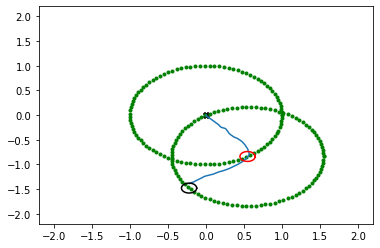

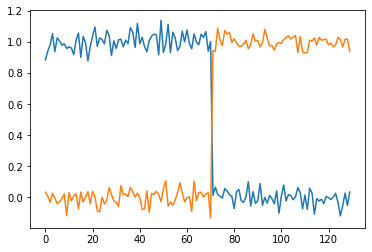

In [469]:
#btn_theta = random.random()*2*np.pi

Rs = []
dists = []

for th in range(1):#np.linspace(0,1,30,endpoint=False):
    
    btn_theta = random.random()*2*np.pi
    targ_theta = random.random()*2*np.pi
    
    btn_dist = 1.0
    targ_dist = 1.0
    
    btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    targ_test = np.array(btn_test) + np.array((btn_dist * np.cos (targ_theta), btn_dist * np.sin (targ_theta)))
    
    POSITION, ACTIONS, context, S_soma, S_wind, B_filt, R, min_btn_dist = make_test(btn_test, targ_test, show_plot=True)
    
    Rs.append(R)
    dists.append(min_btn_dist)
    
    plt.plot(context)
    plt.show()

In [465]:
## save this test for plot

this_POSITION = POSITION
this_ACTIONS = ACTIONS
this_context = context
this_S_soma = S_soma
this_S_wind = S_wind
this_B_filt = B_filt
this_R = R
this_min_btn_dist = min_btn_dist

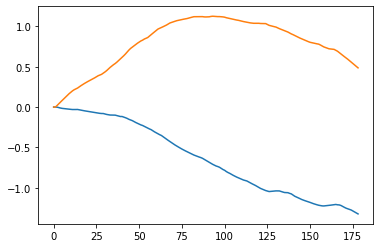

In [209]:
plt.plot(POSITION)
plt.show()

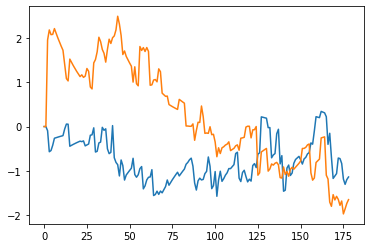

In [210]:
plt.plot(ACTIONS)
plt.show()

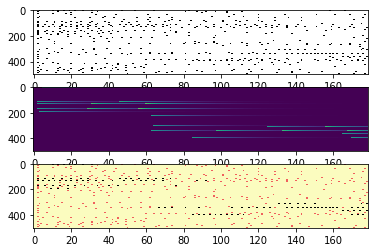

In [213]:
plt.subplot(311)
plt.imshow(1-S_soma[:,0:len(POSITION)], aspect='auto', cmap='gray')
plt.subplot(312)
plt.imshow(B_filt[:,0:len(POSITION)], aspect='auto')
plt.subplot(313)
plt.imshow(1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)]), aspect='auto', cmap='magma')
plt.show()

1- contesto (2)
2- velocita'
3- spike colorati

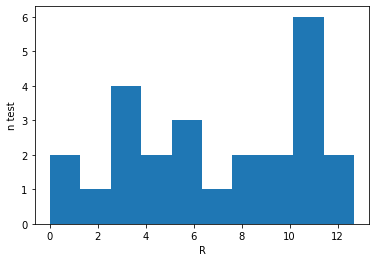

In [39]:
plt.figure()
plt.xlabel('R')
plt.ylabel('n test')
plt.hist(Rs)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (30,) and (25,)

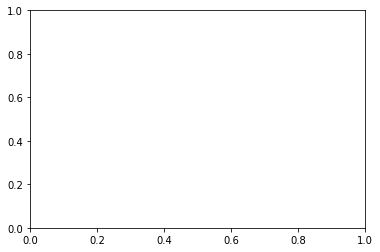

In [38]:
plt.plot(np.linspace(0,1,30)*360,Rs,marker='.')
plt.ylabel('R')
plt.show()

plt.title('n_examples = %d' % n_examples)
plt.plot(np.linspace(0,1,30)*360,dists,marker='.')
plt.plot([0,360],[0.1,0.1],ls='--',color='red')
for th in train_thetas:
    plt.plot([th/2/np.pi*360,th/2/np.pi*360],[0,1],ls='--',color='black',lw=0.5)
plt.ylabel('min dist from btn')
plt.show()

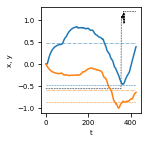

In [389]:
fs = 7

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(figsize=(5*cm, 5*cm))

axes.plot(np.array(POSITION).T[0], zorder=1, color='C0')
axes.plot(np.array(POSITION).T[1], zorder=1, color='C1')
axes.plot([btn_test[0] for _ in range(len(POSITION))], color='C0', ls='--', lw=0.5)
axes.plot([btn_test[1] for _ in range(len(POSITION))], color='C1', ls='--', lw=0.5)
axes.plot([targ_test[0] for _ in range(len(POSITION))], color='C0', ls='-.', lw=0.5)
axes.plot([targ_test[1] for _ in range(len(POSITION))], color='C1', ls='-.', lw=0.5)
axes.plot(np.array(context).T[1], ls='--', color='black', lw=0.5, zorder=0)
axes.set_xlabel('t', fontsize=fs)
axes.set_ylabel('x, y', fontsize=fs)
axes.tick_params(axis='both', which='major', labelsize=fs)
#axes.text(0.5,0.5,'abc',fontsize=fs,ha='center',va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.25, bottom=0.2, right=0.95, top=0.95, wspace=None, hspace=None)
plt.savefig('./fig1.eps')
plt.savefig('./fig1.pdf')
plt.show()

In [494]:
M1 = [S_soma[i][j] if S_wind[i][j]==0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M2 = [S_soma[i][j] if S_wind[i][j]>0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(S_soma))
M2 = np.array(M2).reshape(np.shape(S_soma))

v1 = []
v2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)

w1 = []
w2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

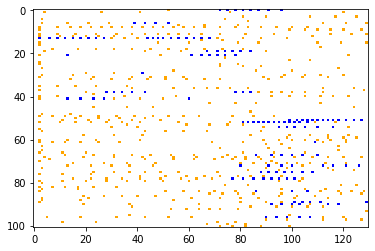

In [471]:
#colors = 'None orange'.split()
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)

plt.imshow(M1[150:251,0:len(POSITION)], cmap=cmap1, aspect='auto')

#colors = 'None blue'.split()
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)

plt.imshow(M2[150:251,0:len(POSITION)], cmap=cmap2, aspect='auto')

plt.show()

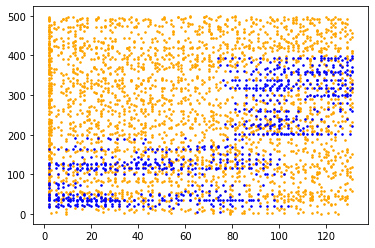

In [512]:
plt.scatter(v2,v1,color='orange',marker='.',s=10)
plt.scatter(w2,w1,color='blue',marker='.',s=10)
#plt.xlim([0,500])
#plt.ylim([0,100])
plt.show()

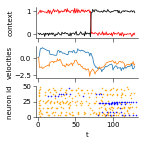

In [519]:
fs = 7
final_dpi = 200

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5*cm, 5*cm))

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

ax = axes[0]
ax.plot(np.array(context).T[0], ls='-', color='red', lw=0.75, zorder=0)
ax.plot(np.array(context).T[1], ls='-', color='black', lw=0.75, zorder=0)
ax.set_ylabel('', fontsize=fs)
ax.set_ylim([-0.2,1.2])
ax.xaxis.set_ticklabels([])
ax.set_xlim([-3,len(POSITION)+3])
ax.text(-0.25, 0.5, 'context', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

ax = axes[1]
ax.plot(np.array(ACTIONS).T[0], zorder=1, color='C0', lw=0.75)
ax.plot(np.array(ACTIONS).T[1], zorder=1, color='C1', lw=0.75)
ax.set_ylabel('', fontsize=fs)
ax.xaxis.set_ticklabels([])
ax.set_xlim([-3,len(POSITION)+3])
ax.text(-0.25, 0.5, 'velocities', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

N_neur = 25
ax = axes[2]
#ax.imshow(B_filt[0:401,:len(POSITION)+2], zorder=1, aspect='auto')
#ax.imshow(1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)]), aspect='auto', cmap='magma')
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)
#ax.imshow(M1[200-N_neur:200+N_neur+1,0:len(POSITION)], cmap=cmap1, aspect='auto', vmin=0, vmax=1)
#ax.imshow(M2[200-N_neur:200+N_neur+1,0:len(POSITION)], cmap=cmap2, aspect='auto', vmin=0, vmax=1)
for i in range(len(v1)):
    if(v1[i]>176 and v1[i]<224):
        y = v1[i]
        ax.scatter(v2[i], y, color='orange', marker='.', s=1)
for i in range(len(w1)):
    if(w1[i]>176 and w1[i]<224):
        y = w1[i]
        ax.scatter(w2[i], y, color='blue', marker='.', s=1)
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([-3,len(POSITION)+3])
#ax.set_ylim([2*N_neur,0])
ax.set_ylim([200+N_neur,200-N_neur])
ax.set_yticks([200+N_neur,200,200-N_neur])
ax.yaxis.set_ticklabels([0,25,50])
ax.text(-0.25, 0.5, 'neuron id', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.17, right=0.95, top=0.95, wspace=None, hspace=0.25)
plt.savefig('./fig2.eps', dpi=final_dpi)
plt.savefig('./fig2.pdf', dpi=final_dpi)
plt.show()

In [351]:
len(M2[150:251,:])

101

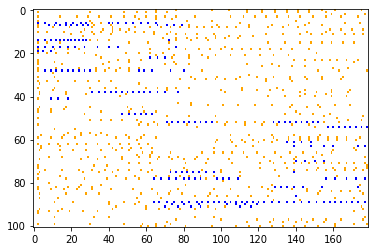

In [292]:
import matplotlib

#colors = 'None orange'.split()
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)

plt.imshow(M1[150:251,0:len(POSITION)], cmap=cmap1, aspect='auto')

#colors = 'None blue'.split()
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)

plt.imshow(M2[150:251,0:len(POSITION)], cmap=cmap2, aspect='auto')

plt.show()

In [251]:
M = 1-(S_soma[:,0:len(POSITION)])*(0.5+S_wind[:,0:len(POSITION)])
print(np.shape(M))
M2 = M
print(np.shape(M))
plt.hist(M)
plt.show()

(500, 179)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [249]:
88400/500

176.8

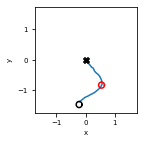

In [520]:
fs = 7
final_dpi = 200
sq_size = 1.75

cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(figsize=(5*cm, 5*cm))

axes.scatter(0,0,marker='X',color='black', zorder=2)
axes.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-', zorder=1)
axes.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-', zorder=2)
axes.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-', zorder=2)
#axes.plot([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='black', ls='--', lw=0.5, zorder=0)
#axes.plot([btn_test[0]+1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[btn_test[1]+1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='black', ls='--', lw=0.5, zorder=0)
#axes.plot(np.array(context).T[1], ls='--', color='black', lw=0.5, zorder=0)
axes.set_xlabel('x', fontsize=fs)
axes.set_ylabel('y', fontsize=fs)
axes.tick_params(axis='both', which='major', labelsize=fs)
#axes.text(0.5,0.5,'abc',fontsize=fs,ha='center',va='center')
axes.set_xlim([-sq_size,sq_size])
axes.set_ylim([-sq_size,sq_size])
axes.set_xticks([-1,0,1])
axes.set_yticks([-1,0,1])
plt.tight_layout()
plt.subplots_adjust(left=0.23, bottom=0.2, right=0.95, top=0.95, wspace=None, hspace=None)
plt.savefig('./fig3.eps', dpi=final_dpi)
plt.savefig('./fig3.pdf', dpi=final_dpi)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y.T)
    plt.plot(lttb.y_targ.T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.B_filt[0:150,:],aspect='auto')

In [290]:
train_thetas

[2.52299293616753,
 0.969591500857559,
 1.140708900302102,
 3.0029161643653492,
 0.2310405821856491,
 0.6681815597950457,
 1.6523718323579166,
 0.6707626586301276,
 5.261259910639258,
 4.575919047460333,
 3.91796055546683,
 6.213717040553316,
 2.850080279385435,
 6.160270525171928,
 5.325837119068753,
 5.354466268829198,
 1.4029414667225832,
 5.5067320269454,
 3.988463532280372,
 5.016327747526899]

In [27]:
np.array(POSITION)[0,:]
print( np.sqrt( np.sum((np.array(POSITION)[50,:] - btn_test)**2) ) )

NameError: name 'POSITION' is not defined

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(POSITION[0,:])
plt.plot(POSITION[1,:])
plt.subplot(212)

plt.plot(context)

In [74]:
TIME_TEST = 1500

par['T'] = TIME_TEST
lttb.T = TIME_TEST

REWARDS = []

for rep in range(20):

    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = (np.random.rand(2)-.5)
    btn_test = (np.random.rand(2)-.5)

    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = np.zeros((2,TIME_TEST))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION[:,t] = agen
        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) ) < 0.1:
            done = 1

        if done: break
            
    REWARDS.append(R)

    print('R = ' + str(R))

    


R = 0
R = 0
R = 0
R = 0
R = 4.626371807823789
R = 0
R = 10.341577828430156
R = 10.271286194102471
R = 0
R = 5.636280050593238
R = 0
R = 0
R = 0
R = 0
R = 0
R = 4.796671672409694
R = 0
R = 10.042919213210986
R = 0
R = 0


Text(0.5, 0, 'Reward')

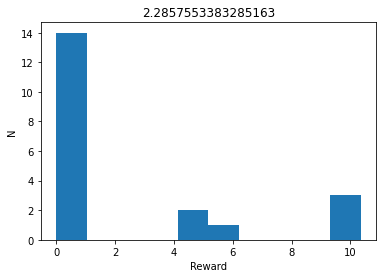

In [75]:
plt.hist(REWARDS)
plt.title(np.array(REWARDS).mean())
plt.ylabel("N")
plt.xlabel("Reward")